# Balanced Iterative Reducing and Clustering using Hierarchies (BIRCH)

[**Source**] Clustering technique used in paper, **A Collaborative Computer Aided Diagnosis (C-CAD) System with Eye-Tracking, Sparse Attentional Model, and Deep Learning** (https://arxiv.org/abs/1802.06260).

### **What's BIRCH algorithm**

Balanced Iterative Reducing and Clustering using Hierarchies (BIRCH) is a clustering algorithm that is commonly used for data mining and machine learning. It was developed by Tian Zhang, Raghu Ramakrishnan, and Miron Livny in 1996.

BIRCH is a memory-efficient algorithm that can handle large datasets. It works by recursively clustering the data using a hierarchical approach. The algorithm first builds a tree structure called the Cluster Feature Tree (CFT) by recursively clustering the data points. The CFT has a hierarchical structure, where each node represents a sub-cluster and the root node represents the entire dataset. The nodes in the CFT are linked to form a tree using a clustering algorithm called CF (Clustering Feature).

BIRCH uses a distance-based clustering criterion to decide whether to merge two sub-clusters or create a new one. The distance between two sub-clusters is calculated based on their proximity in the feature space. BIRCH also uses a clustering threshold, which determines the maximum diameter of a sub-cluster. If a sub-cluster exceeds this threshold, it is split into smaller sub-clusters.

The BIRCH algorithm has several advantages. First, it can handle large datasets efficiently since it only needs to store the CFT in memory. Second, it is scalable and can handle streaming data. Third, it is flexible and can handle different types of data.

However, BIRCH also has some limitations. It is sensitive to the choice of parameters, such as the clustering threshold and the CF distance metric. It also assumes that the data is roughly spherical and equally distributed, which may not always be the case in real-world datasets.

# What are the parameters?

- `threshold` ($T$): The radius of the subcluster obtained by merging a new sample and the closest subcluster should be lesser than the threshold. Otherwise a new subcluster is started. Setting this value to be very low promotes splitting and vice-versa.
- `branching_factor` ($L$): Maximum number of CF subclusters in each node.


## Visualise the cluster feature (CF) Tree generation.

####  Clustering Process 
This clustering algorithm consider the instances one by one (order matters). The first instance $i_{1}$ create the CF, $A$.

![](./BIRCH/1.png)

Let $T$ be the `threshold` distance, and $C_{A}$ to be centre of the A CF.  When the second instance $i_{2}$ come in, if $\text{distance}(C_{A},i_{2})<T$, the $i_{2}$ will belong to cluster $A$.

![](./BIRCH/2.png)

When $\text{distance}(C_{A},i_{3})> T$, another cluster $B$ will be created. 

![](./BIRCH/3.png)

Then we continue to do this:

![](./BIRCH/4.png)

Until `branching_factor`, $L=3$, is reached. When a CF exceed the maximum number of CF subclusters:

![](./BIRCH/5.png)

This CF will be split into two CFs. 

![](./BIRCH/6.png)

Because the root contains more than 3 CFs, it's split into 2 subclusters again.

![](./BIRCH/7.png)



### **What does BIRCH differ from other clustering algorithm?**

##### **Pros**:

Scalability: BIRCH can handle very large datasets efficiently by incrementally building a tree-based data structure, known as the Cluster Feature Tree (CFT), which summarizes the data and enables efficient clustering.
Robustness to noise: BIRCH can handle noisy and outlier-prone datasets by using a clustering threshold that limits the diameter of subclusters.
Memory efficiency: BIRCH can efficiently handle datasets with low memory constraints as it only requires a single scan of the data and maintains a condensed representation of the data in the CFT.
Ability to handle streaming data: BIRCH can handle streaming data, meaning that it can incrementally update the CFT as new data points arrive and adapt to changes in the underlying data distribution.
Does not require pre-specified number of clusters: BIRCH can automatically determine the number of clusters from the data.


##### **Cons**:

Not suitable for all types of data: BIRCH works best with datasets that have a globular structure, where the clusters are tightly packed and have similar diameters. It may not perform as well on datasets with complex or irregular structures.
May produce suboptimal clustering results: BIRCH can produce suboptimal clustering results when the shape of the clusters is not spherical, and the variance within clusters is not uniform.
Limited applicability to high-dimensional data: BIRCH's performance can degrade for high-dimensional data due to the curse of dimensionality.
Sensitivity to hyperparameters: The clustering threshold and branching factor parameters in BIRCH can significantly impact the resulting clustering, and tuning these parameters can be challenging.
Requires careful pre-processing of data: The performance of BIRCH can be sensitive to the pre-processing steps such as scaling and normalization of the data.

### **what's the parameters used in the paper?**
They are not mentioned in the paper.

In [1]:
import pandas as pd 
import numpy as np
from sklearn.cluster import Birch
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
import networkx as nx

# Gaze data

Since gaze data doesn't provide the duration, the only two important columns are `X_ORIGINAL` and `Y_ORIGINAL`. Some of the gaze points has a `null` value in their `X_ORIGINAL` or `Y_ORIGINAL`, which will be filtered out.

In [2]:
img_width, img_height = 2544, 3056
gaze_df = pd.read_csv("./patient_18087960/EyeGaze/eye_gaze.csv")
gaze_df = gaze_df[['X_ORIGINAL', 'Y_ORIGINAL']]
gaze_df.columns = ['x_position', 'y_position']
gaze_df = gaze_df[gaze_df['x_position'].between(0, img_width)]
gaze_df = gaze_df[gaze_df['y_position'].between(0, img_height)]
gaze_df = gaze_df[~(gaze_df['x_position'].isna() | gaze_df['y_position'].isna())]
gaze_df.head(5)

x_position  y_position
0        2248         345
1        2224         371
2        2222         392
3        2219         411
4        2217         424

In [3]:
gaze_points = np.array([(x,y) for x, y in zip(gaze_df['x_position'], gaze_df['y_position'])])

# Coordinate 
In here, instead of normalising the given eye-tracking data in this specific image. We set the centre of image as (0, 0), and the edge of image to (1, -1).

<!-- <img src="./patient_18087960/CXR-JPG/s59570639/8afc3991-7ec1912b-b24d9633-3c4b0f57-17c0e8f4.jpg"  width="600"> -->
<img src="./BIRCH/coord.jpg"  width="600">


*Have another version using `mean` and `std`*

In [4]:
centre_x = img_width/2
centre_y = img_height /2
norm_gaze_points = (gaze_points - np.array([centre_x, centre_y])) / np.array([centre_x, centre_y])

# Parameters
The parameters they provided by the skleran library. If `n_clusters` is not `None`. Then, the `branching_factor` will be ignored. 

In [5]:
# Choose clustering parameters
threshold = 0.1 # clustering threshold
branching_factor = 150 # branching factor
n_clusters = None  # number of clusters (None means BIRCH will choose automatically)

# Clustering using `Birch` from sklearn library.

In [6]:
# Initialize the BIRCH algorithm
birch = Birch(threshold=threshold, branching_factor=branching_factor, n_clusters=n_clusters)

# Fit the BIRCH algorithm to the gaze point data
birch.fit(norm_gaze_points)

# Generate the clustering output
subcluster_labels = birch.predict(norm_gaze_points)

# Visualisation

### Visualise in the coordinate range [1, -1].

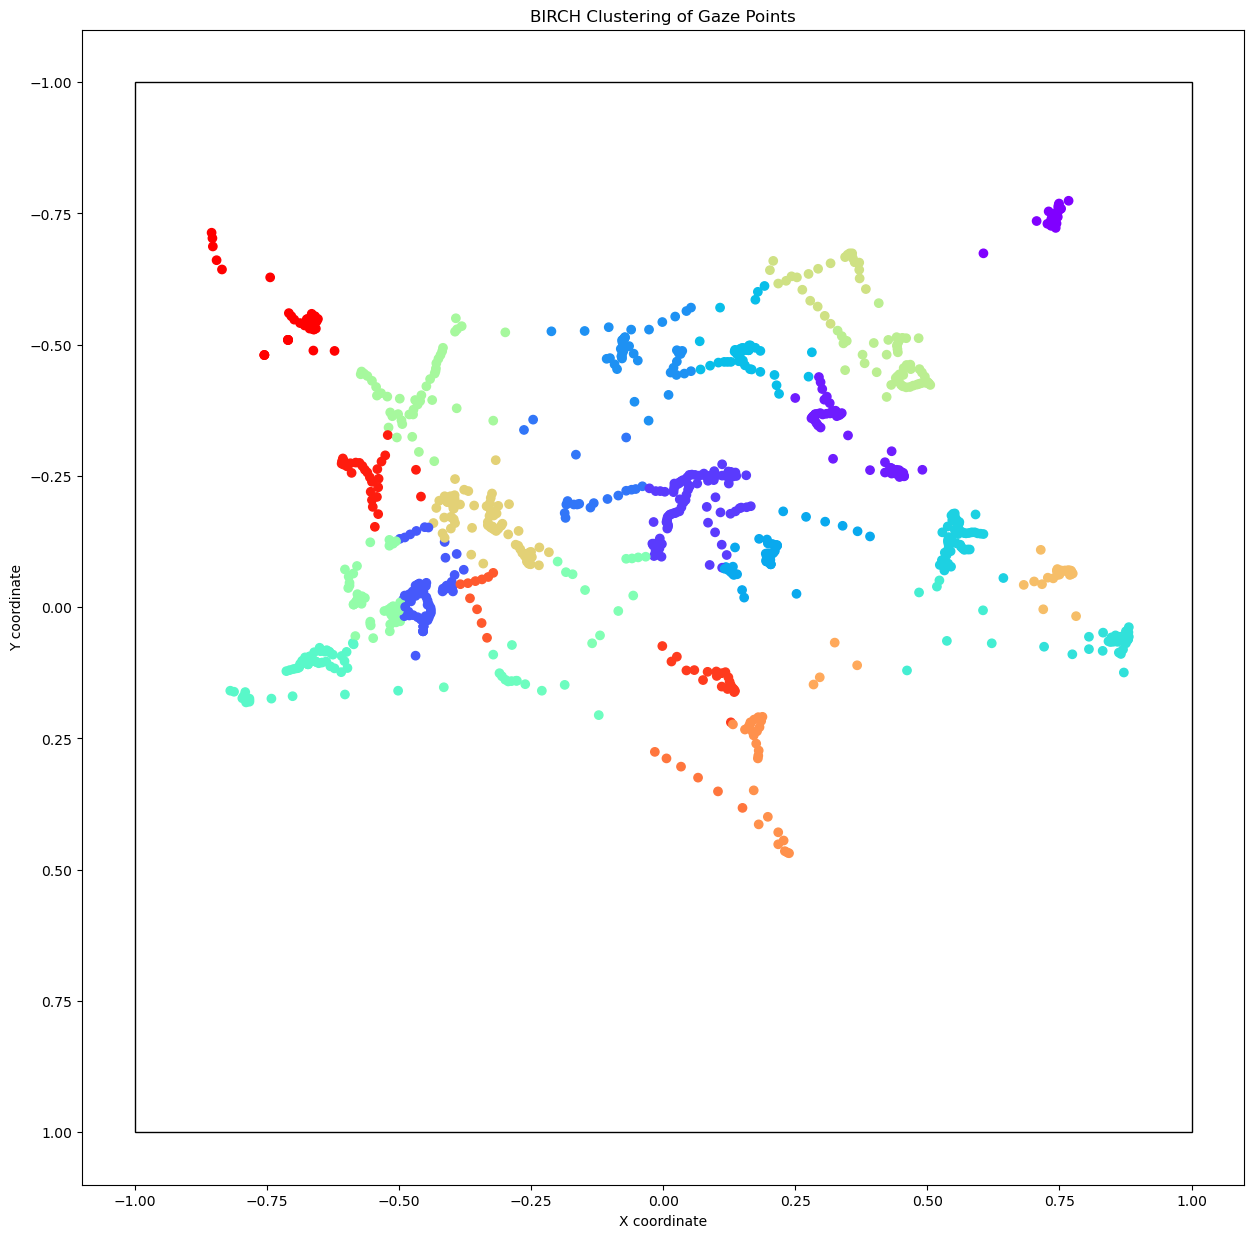

In [7]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.gca().invert_yaxis()
# Visualize the clustering results
plt.scatter(norm_gaze_points[:, 0], norm_gaze_points[:, 1], c=subcluster_labels, cmap='rainbow')
ax.add_patch(Rectangle((-1, -1), 2, 2, fill=False))
plt.title('BIRCH Clustering of Gaze Points')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.show()

### Visualise on chest X-ray image

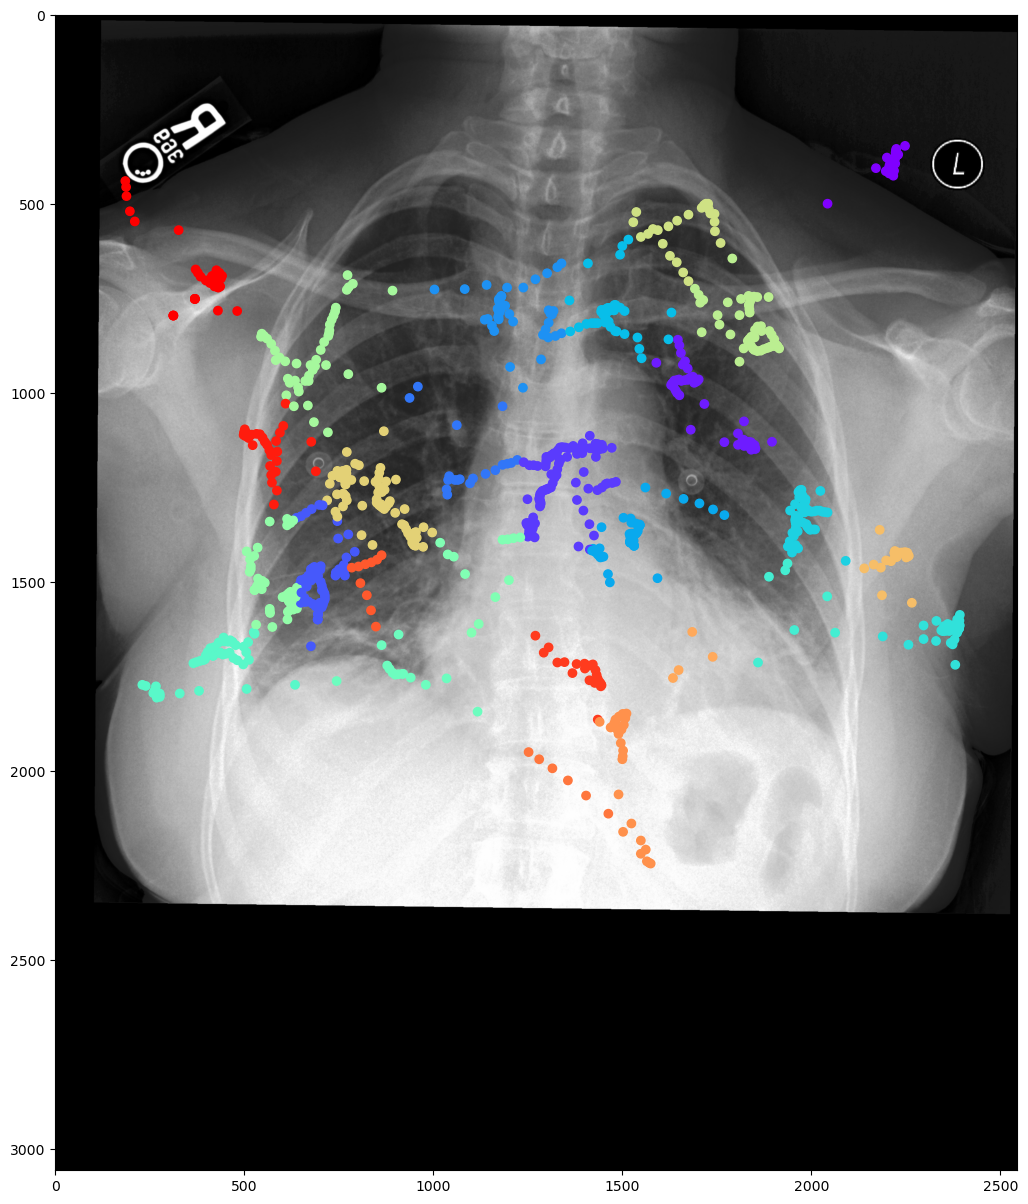

In [8]:
cxr = Image.open('./BIRCH/cxr.jpg').convert("RGB")
fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(cxr)
plt.scatter((norm_gaze_points[:, 0]*centre_x)+centre_x , (norm_gaze_points[:, 1]*centre_y)+centre_y, c=subcluster_labels, cmap='rainbow')

### With anatomical BB

In [9]:
anatomical_df = pd.read_csv("./patient_18087960/EyeGaze/bounding_boxes.csv")

In [10]:
anatomical_df['bbox_name']

0           cardiac silhouette
1                left clavicle
2      left costophrenic angle
3        left hilar structures
4         left lower lung zone
5                    left lung
6           left mid lung zone
7         left upper lung zone
8               right clavicle
9     right costophrenic angle
10      right hilar structures
11       right lower lung zone
12                  right lung
13         right mid lung zone
14       right upper lung zone
15                     trachea
16           upper mediastinum
Name: bbox_name, dtype: object

In [11]:
anatomical_cmap = {
        "cardiac silhouette": "yellow",
        "left clavicle": "orange",
        "right clavicle": "orange",
        "left costophrenic angle": "royalblue",
        "right costophrenic angle": "royalblue",
        "left hilar structures": "bisque",
        "right hilar structures": "bisque",

        "left lung": "tomato",
        "right lung": "tomato",

        "trachea": "plum",
        "upper mediastinum": "darkseagreen",

        # "left lower lung zone": "lime",
        # "right lower lung zone": "lime",
        # "left mid lung zone": "slategray",
        # "right mid lung zone": "slategray",
        # "left upper lung zone": "darkviolet",
        # "right upper lung zone": "darkviolet",
    }

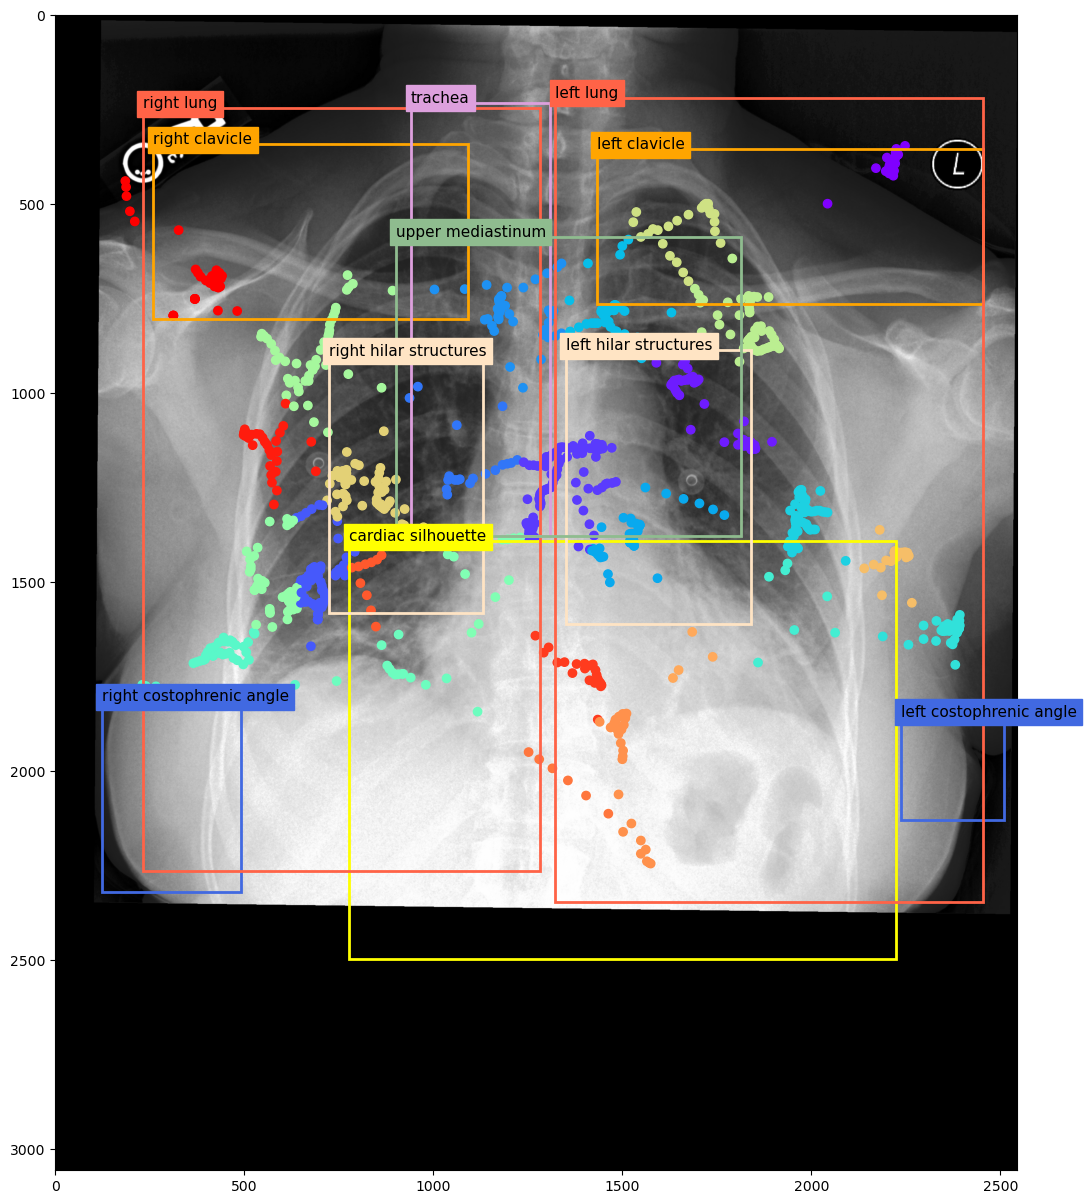

In [12]:
EYEGAZE_COORD_COLS = ["x1", "y1", "x2", "y2"]
anatomical_df = pd.read_csv("./patient_18087960/EyeGaze/bounding_boxes.csv")

cxr = Image.open("./BIRCH/cxr.jpg").convert("RGB")
fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(cxr)
plt.scatter(
    (norm_gaze_points[:, 0] * centre_x) + centre_x,
    (norm_gaze_points[:, 1] * centre_y) + centre_y,
    c=subcluster_labels,
    cmap="rainbow",
)

for _, bb in anatomical_df.iterrows():
    bbox = list(bb[EYEGAZE_COORD_COLS])
    bbox_name  = bb['bbox_name']

    if not (bbox_name in anatomical_cmap):
        continue

    c = anatomical_cmap[bbox_name]
    ax.add_patch(
        Rectangle(
            (bbox[0], bbox[1]),
            bbox[2] - bbox[0],
            bbox[3] - bbox[1],
            fill=False,
            color=c,
            linewidth=2,
        )
    )
    ax.text(
        bbox[0],
        bbox[1],
        bbox_name,
        color="black",
        backgroundcolor=c,
        fontdict={"size": 11},
    )


### Just the centroids of clusters. 

Number of the clusters: [27]


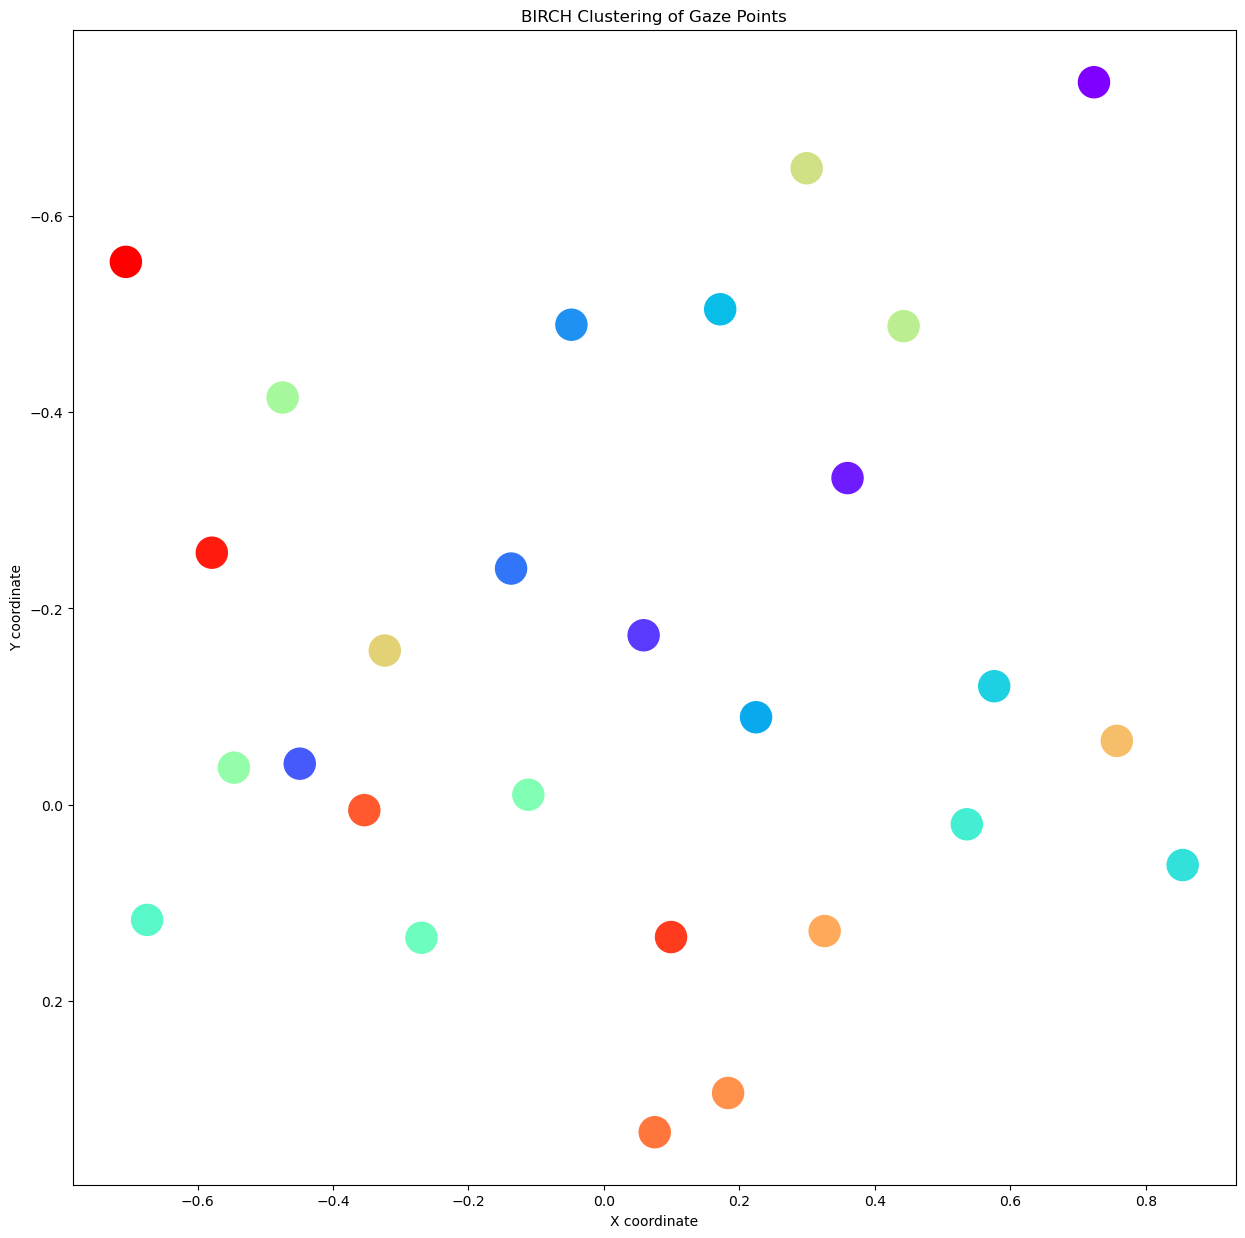

In [13]:
num_clusters = len(birch.subcluster_labels_)
print(f"Number of the clusters: [{num_clusters}]")
fig, ax = plt.subplots(figsize=(15, 15))
norm_centroid_x = birch.subcluster_centers_[:, 0]
norm_centroid_y = birch.subcluster_centers_[:, 1]
plt.scatter(norm_centroid_x, norm_centroid_y, c=birch.subcluster_labels_, cmap='rainbow', s=500)
plt.gca().invert_yaxis()
ax.add_patch(Rectangle((-1, -1), 2, 2, fill=False))
plt.title('BIRCH Clustering of Gaze Points')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.show()

### Centroids on the chest X-ray image.

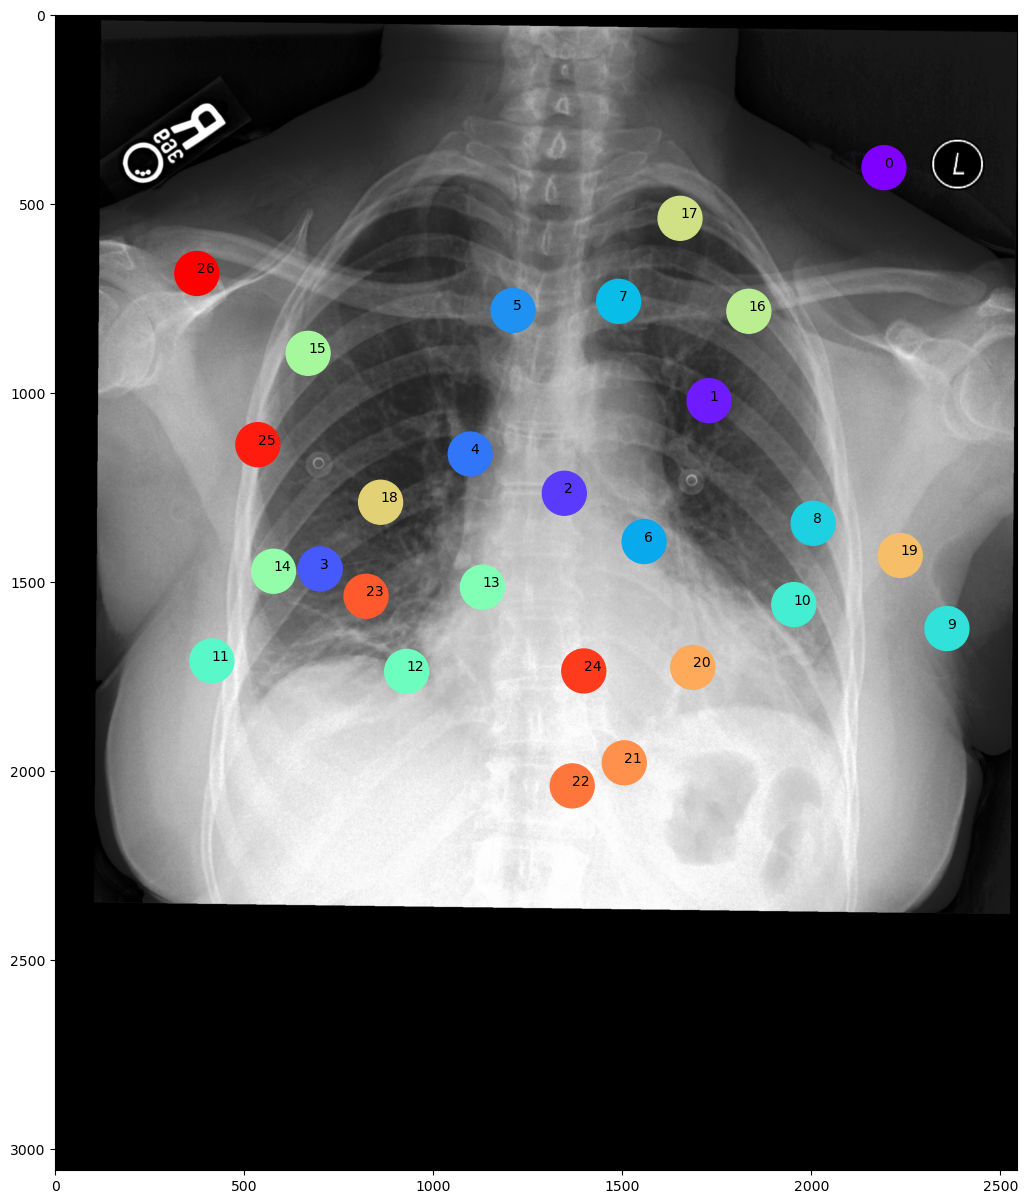

In [14]:
fig, ax = plt.subplots(figsize=(15, 15))
cxr = Image.open('./BIRCH/cxr.jpg').convert("RGB")
plt.imshow(cxr)

centroids_x = (norm_centroid_x*centre_x)+centre_x
centroids_y = (norm_centroid_y*centre_y)+centre_y
ax.scatter(centroids_x, centroids_y, c=birch.subcluster_labels_, cmap='rainbow', s=1000)
for x,y, t in zip(centroids_x, centroids_y,  birch.subcluster_labels_):
    ax.annotate(t, (x, y), )

### With bounding boxes

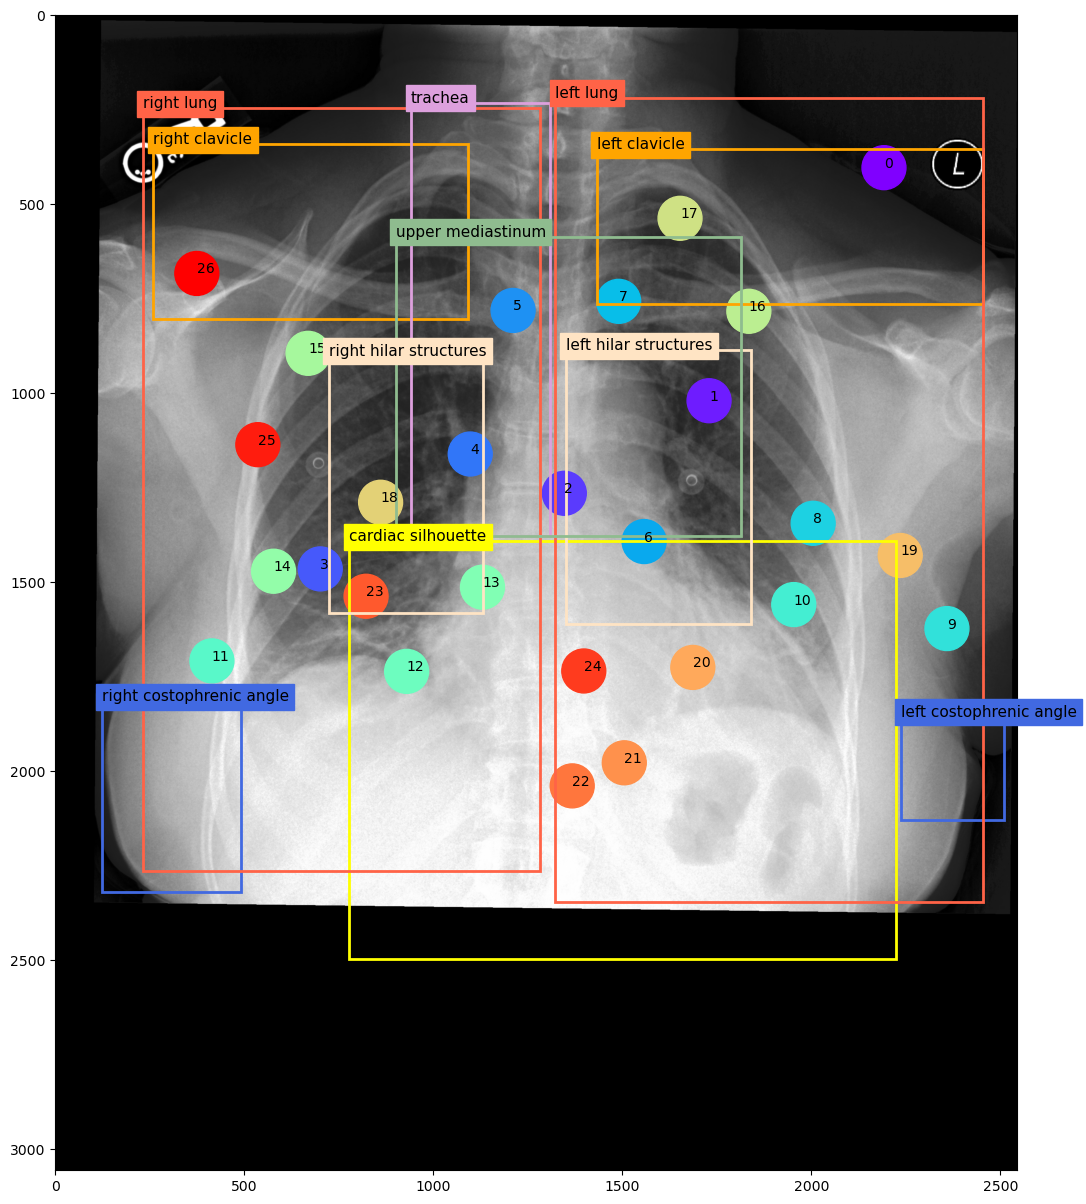

In [15]:
fig, ax = plt.subplots(figsize=(15, 15))
cxr = Image.open('./BIRCH/cxr.jpg').convert("RGB")
plt.imshow(cxr)

centroids_x = (norm_centroid_x*centre_x)+centre_x
centroids_y = (norm_centroid_y*centre_y)+centre_y
ax.scatter(centroids_x, centroids_y, c=birch.subcluster_labels_, cmap='rainbow', s=1000)
for x,y, t in zip(centroids_x, centroids_y,  birch.subcluster_labels_):
    ax.annotate(t, (x, y), )
    

for _, bb in anatomical_df.iterrows():
    bbox = list(bb[EYEGAZE_COORD_COLS])
    bbox_name  = bb['bbox_name']

    if not (bbox_name in anatomical_cmap):
        continue

    c = anatomical_cmap[bbox_name]
    ax.add_patch(
        Rectangle(
            (bbox[0], bbox[1]),
            bbox[2] - bbox[0],
            bbox[3] - bbox[1],
            fill=False,
            color=c,
            linewidth=2,
        )
    )
    ax.text(
        bbox[0],
        bbox[1],
        bbox_name,
        color="black",
        backgroundcolor=c,
        fontdict={"size": 11},
    )



# Graph creation
After we have konwn which gaze point belong to which cluter. We can start creeating the centroid graph.

### Step [1]: create a directed adjacency matrix.

In [16]:
# assign cluster to each gaze point.
gaze_df['cluster'] = subcluster_labels.astype(int)

# create the directed adjacency matrix (it will be later be transformed to undirected to use the following sparsification method.)
directed_adjacency =  np.zeros((num_clusters, num_clusters)).astype(int)
print(f"the shape of the adjacency matrix is: [{directed_adjacency.shape}]")

the shape of the adjacency matrix is: [(27, 27)]


#### [Note] Edge setting.
Three points are provided in the paper:

1. all the vertices pertaining to each cluster are removed except the centroid of the cluster,
2. all the edges that were connecting vertices from different clusters now connect the corresponding centroids, and
3. all the edges that were connecting vertices inside each cluster are modeled as self loops on the centroid.



In [17]:
for i in range(len(gaze_df)-1):
    u_cluster = gaze_df.iloc[i]['cluster'] 
    v_cluster = gaze_df.iloc[i+1]['cluster'] 
    directed_adjacency[int(u_cluster), int(v_cluster)] += 1 

### Step [2]: transform the directed adjacency matrix into undirected.

In [18]:
undirected_adjacency = directed_adjacency + directed_adjacency.T

# divide the diagonal by two since we just added them.
for i in range(len(undirected_adjacency)):
    undirected_adjacency[i, i] /=2

### Step [3]: create the graph.

In here, **netwrokx** library is used to create the graph, then we add the nodes and edges according to their coordinates and adjacency matrix.

In [19]:
G = nx.Graph()
# Add nodes to the graph and set their positions
for i, (x, y) in enumerate(zip(norm_centroid_x, norm_centroid_y)):
    G.add_node(i, pos=(x,y))
    
# Add edges to the graph and set their weights
for i in range(len(undirected_adjacency)):
    for j in range(len(undirected_adjacency[i])):
        if undirected_adjacency[i][j] > 0:
            G.add_edge(i, j, weight=undirected_adjacency[i][j])

### Step [4]: Visualise the graph

Since networkx doesn't support self loop well, the weights of edges are blocked by the vertices. But it can still be seen by the width of the edges. In here, we find self loop has most of the weights.

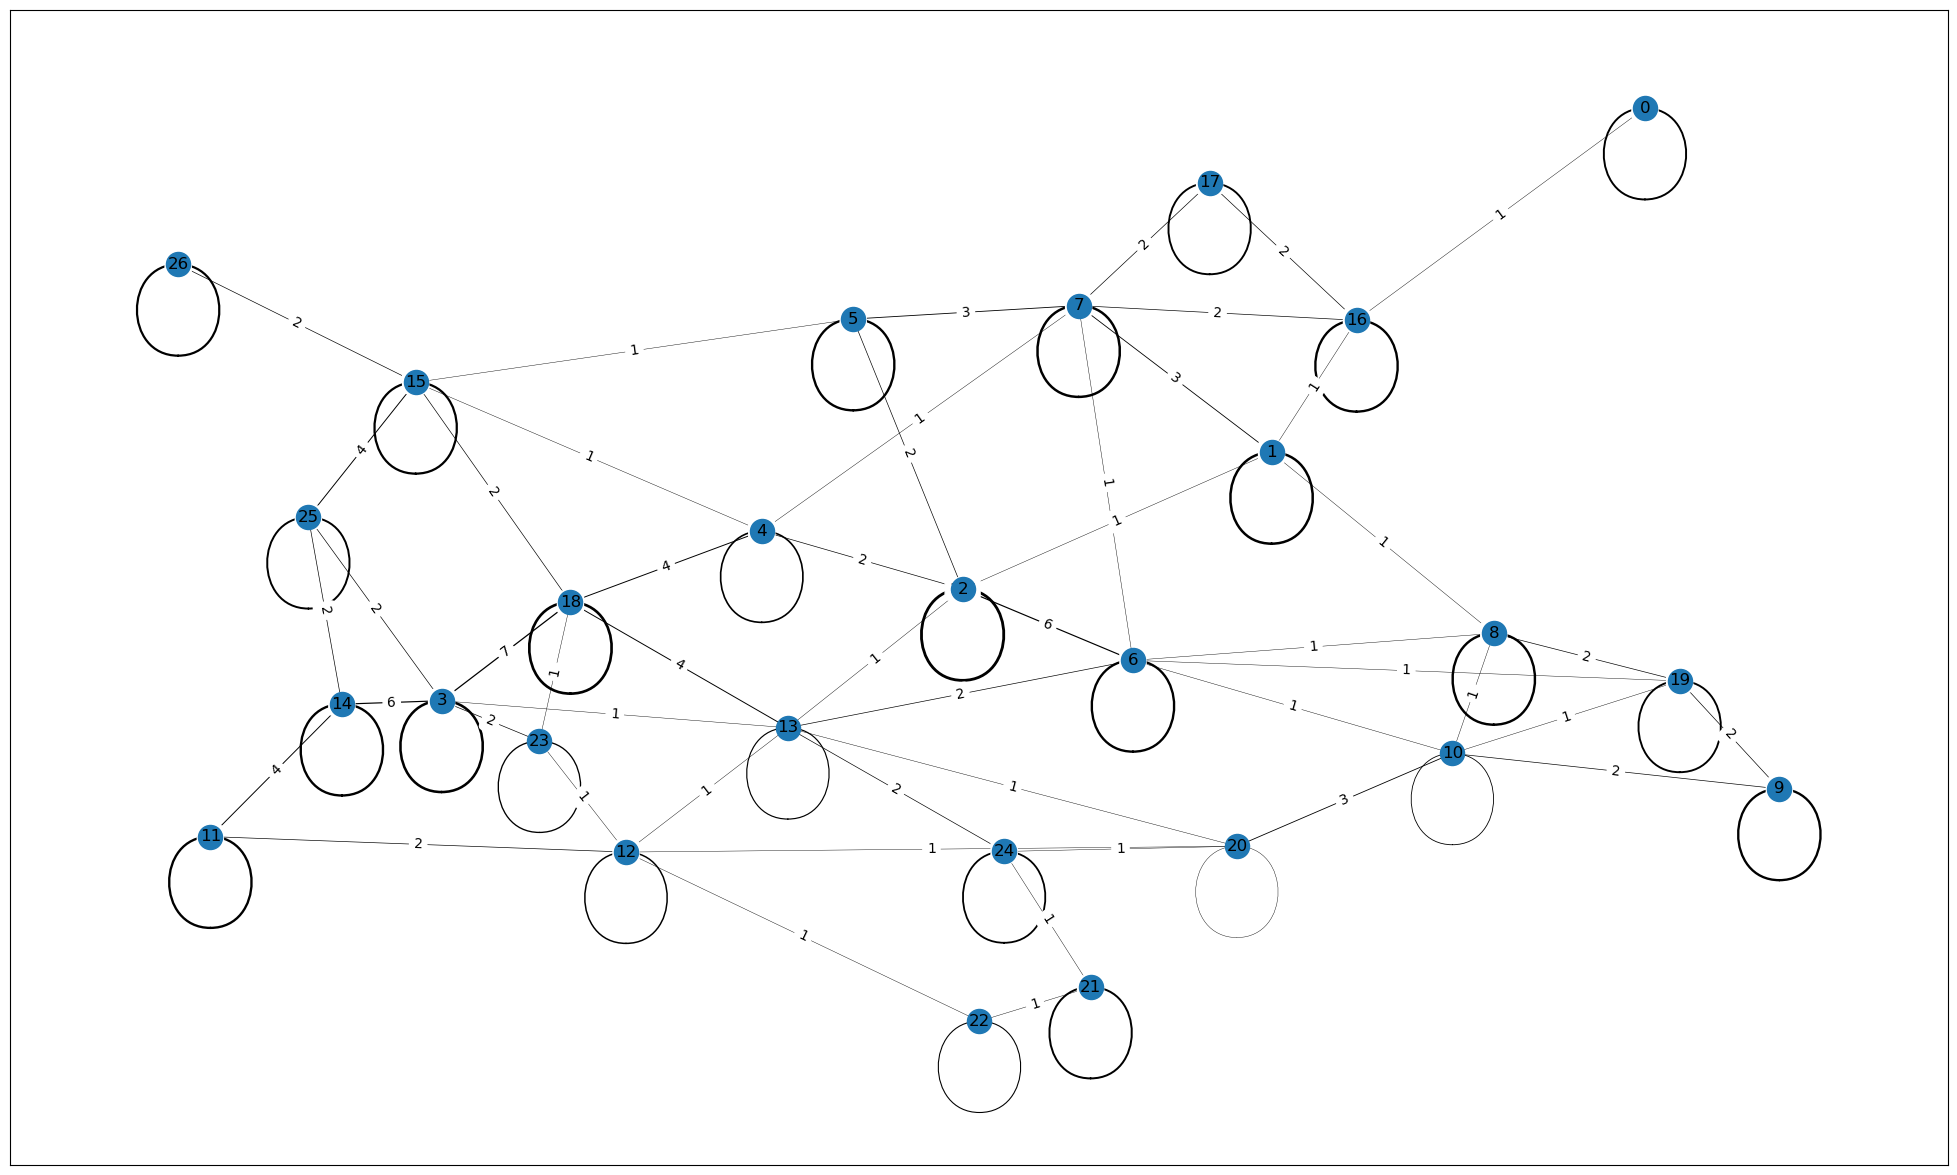

In [20]:
plt.figure(figsize=(25,15)) 
plt.gca().invert_yaxis()
pos = nx.get_node_attributes(G, 'pos')
edge_weights = nx.get_edge_attributes(G, 'weight')
edge_widths = [np.log10(w + 1) for (_, _, w) in G.edges(data='weight')]
nx.draw_networkx(G, pos=pos, with_labels=True, width=edge_widths)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights)
plt.show()

### On CXR

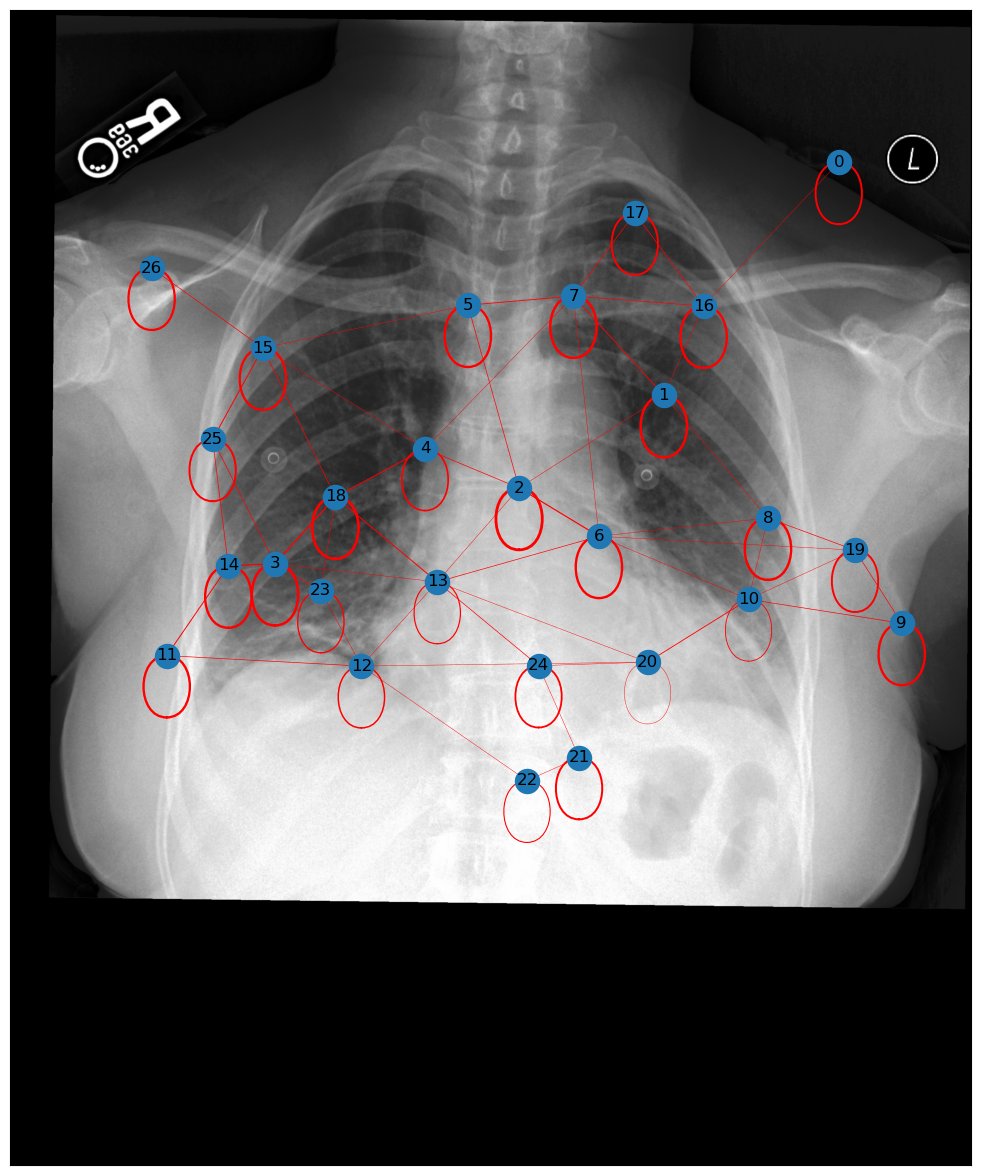

In [21]:
from PIL import Image
import matplotlib.pyplot as plt
import networkx as nx

cxr = Image.open("./BIRCH/cxr.jpg").convert("RGB")
fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(cxr)
# plt.gca().invert_yaxis()
pos = nx.get_node_attributes(G, 'pos')
for k, p in pos.items():
    pos[k] = ((p[0]*centre_x)+centre_x, (p[1]*centre_y)+centre_y)
edge_weights = nx.get_edge_attributes(G, 'weight')
edge_widths = [np.log10(w + 1) for (_, _, w) in G.edges(data='weight')]
nx.draw_networkx(G, pos=pos, with_labels=True, width=edge_widths, edge_color="red")
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights)
plt.show()

#### [**Q**] undirected graph will rise a concerns for using RNN decoders? => Need to check out what loss function we need, cuz we this function doesn't have a specific order.